<a href="https://colab.research.google.com/github/FattySeagull/Rosenthal-Plateau-Rayleigh/blob/main/Rosenthal_size_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.optimize import fsolve

import matplotlib.pyplot as plt

Christiansen's operating parameter
$$
N = \frac{A P v}{4\pi \kappa \alpha (T_m-T_0)}
$$

In [ ]:
def Christiansen_N(P, v, A, Tm, T0, kappa, alpha):
    return A*P*v/(4.0*np.pi*kappa*alpha*(Tm - T0))

Non-dimensional Rosenthal's solution for a moving point heat source on semi-infinite plate
$$
\frac{\Theta}{N} = \frac{1}{\rho}\exp{(-\rho-\xi)}
$$
where $\rho = \sqrt{\xi^2+\psi^2+\zeta^2}$


In [ ]:
def Rosenthal(xi, eta, psi, N):
    rho = np.sqrt(xi**2+eta**2+psi**2)
    return N*np.exp(-rho-xi)/rho

# Obtaining the width of melt pool
On the peripheral of melt pool, $\Theta = 1$, and $\rho=\rho_m$,
$$
\frac{1}{N} = \frac{1}{\rho}\exp{(-\rho-\xi)}
$$
At the waist of melt pool, $\partial (1/N)/\partial \xi = 0$, or $\partial \ln(1/N)/\partial \xi = 0$,
$$
\frac{\partial \ln(1/N)}{\partial \xi}
 = \frac{\partial \ln(1/N)}{\partial \rho} \frac{\partial \rho}{\partial \xi}
$$
Partial derivatives are
$$
\frac{\partial \rho}{\partial \xi}=\frac{2\xi}{2\sqrt{\xi^2+\psi^2+\zeta^2}}=\frac {\xi} {\rho}
\\
\frac{\partial \ln(1/N)}{\partial \rho} = \frac{\partial}{\partial \rho}(-\ln \rho -\rho -\xi)=-\frac 1 \rho -1 -\frac{\rho}{\xi}
$$

Substituting them
$$
\frac{\partial \ln(1/N)}{\partial \xi} = (-\frac 1 \rho -1)(\frac{\xi}{\rho}) -1
= \frac{-\rho^2-(1+\rho)\xi}{\rho^2} = 0
$$
Then
$$
\xi = -\frac{\rho^2}{1+\rho}
$$
Therefore
$$
\frac{1}{N} = \frac{1}{\rho_m}\exp{(-\frac{\rho_m}{\rho_m+1})}
$$
After obtaining $\rho_m$ by solfing the above non-linear equation,
$$
\xi_m = -{\rho_m^2}/(1+\rho_m) \\
\psi_m = \zeta_m = \sqrt{\rho_m^2-\xi_m^2}=\frac{\rho_m}{1+\rho_m}\sqrt{1+2\rho_m}
$$
$\psi_m$ is the half of he width of melt pool, $w$
$$
w = 2\psi_m
$$


In [ ]:
def Rosenthal_width(N):
    ro =  np.abs(fsolve(lambda y: Rosenthal(0.0, y, 0.0, N) -1.0, 0.1))
    rm = fsolve(lambda x: x*np.exp(x/(1+x))/N - 1.0, ro)[0]
    xm = -rm**2/(1+rm)
    pm = rm/(1+rm)*np.sqrt(1+2*rm)
    w = 2.0*pm
    return w, xm, pm, rm

In [ ]:
def Rosenthal_length(N):
    xi2 = N
    xi1 = fsolve(lambda x: x*np.exp(2*x) - N, 0.01)[0]
    return xi1 + xi2, xi1, xi2

#Reyleigh length to breakout the tail of melt pool

$$
t_b = \left(0.433\sqrt{\frac{\gamma_{LV}}{\rho (w/2)^3}}\right)^{-1}
$$

In [ ]:
def Reyleigh_tb(w, gm, rho):
    return 1.0/(0.3433*np.sqrt(gm/(rho*(w/2)**3)))

In [ ]:
def Reyleigh_ts(v, l):
    return l/v

In [ ]:
def Plot_contour(ax, xx, yy, zz, title = ''):
  contour = ax.contour(xx, yy, zz, colors='black')
  ax.clabel(contour, inline=True, fontsize=16)
  if title != '':
    ax.set_title(title, fontsize=18)
  ax.set_xlabel('Scanning speed, mm/s', fontsize=18)
  ax.set_ylabel('Laser Power, W', fontsize=18)
  ax.tick_params(axis='x', labelsize=16)
  ax.tick_params(axis='y', labelsize=16)
  #ax.set_aspect('equal', adjustable='box')
  ax.grid(linestyle='dashed')

In [ ]:
if __name__ == '__main__':
    # IN718
    mat = 'Inconel 718'
    lmd = 11.4     # thermal conductivity, W/(m K)
    den = 8.19E+03  # density, kg/m3
    cp = 435.0      # specific heat capacity, J/(kg K)
    alph = lmd/(den*cp)    # thermal diffusivity, m2/s
    Tm = 1336.0 # liquidus, degC
    A = 0.3 # laser absorpability

    den2 = 7.580E+3
    gm = 1.82   # surface temsion, N/m

    # パラメータを設定
    T0 = 50.0   # powder bed temp, degC

    P = np.arange(500, 1100 + 50, 50)    # 移動点熱源の熱量,
    v = np.arange(1000, 4000 + 250, 250)*1E-3  # 移動点熱源の速度, m/s
    # P = np.arange(100, 1100 + 100, 100)    # 移動点熱源の熱量,
    # v = np.arange(100, 4000 + 500, 500)*1E-3  # 移動点熱源の速度, m/s
    PP, vv = np.meshgrid(P, v)

    length = []
    width = []
    tb = []
    ts = []
    tr = []
    n = []
    xi0 = []
    xi1 = []
    xi2 = []
    for pe, ve in zip(PP.ravel(), vv.ravel()):
        N = Christiansen_N(pe, ve,  A, Tm, T0, lmd, alph)
        n.append(N)
        print(f'p: {pe:.0f}, v: {ve*1E+3:.0f}, N: {N:.5E}', end=' ')

        w = Rosenthal_width(N)[0]*2.0*alph/ve * 1.0E+6
        width.append(w)
        print(f'w: {w:.0f}', end=' ')

        # x0, x1, x2 = Rosenthal_length(N)
        # xi0.append(x0)
        # xi1.append(x1)
        # xi2.append(x2)
        # l0 = x0 * 2.0*alph/ve * 1.0E+6
        # l1 = x1 * 2.0*alph/ve * 1.0E+6
        # l2 = x2 * 2.0*alph/ve * 1.0E+6
        #length.append([l0, l1, l2])
        #print(f'l: {l0:.0f}, l1: {l1:.3f}, l2: {l2:.0f}', end=' ')
        L = Rosenthal_length(N)[0] * 2.0*alph/ve * 1.0E+6
        length.append(L)
        print(f'L: {L:.0f}', end=' ')

        t1 = Reyleigh_tb(w*1E-6, gm, den2)*1E+6
        t2 = Reyleigh_ts(ve, L*1E-6)*1E+6
        t3 = t1/t2
        tb.append(t1)
        ts.append(t2)
        tr.append(t3)
        print(f'tb: {t1}, ts: {t2}, ratio:{t3}', end=' ')

        print(' ')



p: 500, v: 1000, N: 2.54451E+02 w: 175 L: 1643 tb: 153.4249728700152, ts: 1643.4157741537697, ratio:0.09335736901333873  
p: 550, v: 1000, N: 2.79896E+02 w: 183 L: 1807 tb: 164.8528181170621, ts: 1806.50917594791, ratio:0.0912549021681889  
p: 600, v: 1000, N: 3.05341E+02 w: 191 L: 1970 tb: 176.0223452424863, ts: 1969.5812913299967, ratio:0.08937043929962592  
p: 650, v: 1000, N: 3.30786E+02 w: 199 L: 2133 tb: 186.9603480983335, ts: 2132.6354717335385, ratio:0.08766634081461681  
p: 700, v: 1000, N: 3.56231E+02 w: 207 L: 2296 tb: 197.6889984511558, ts: 2295.67433199003, ratio:0.08611369465449699  
p: 750, v: 1000, N: 3.81676E+02 w: 214 L: 2459 tb: 208.22691625674588, ts: 2458.6999518954376, ratio:0.0846898443611314  
p: 800, v: 1000, N: 4.07121E+02 w: 221 L: 2622 tb: 218.58993726054018, ts: 2621.7140131520728, ratio:0.08337672841658678  
p: 850, v: 1000, N: 4.32566E+02 w: 228 L: 2785 tb: 228.79167710561714, ts: 2784.717895074948, ratio:0.08215973241320354  
p: 900, v: 1000, N: 4.58012E

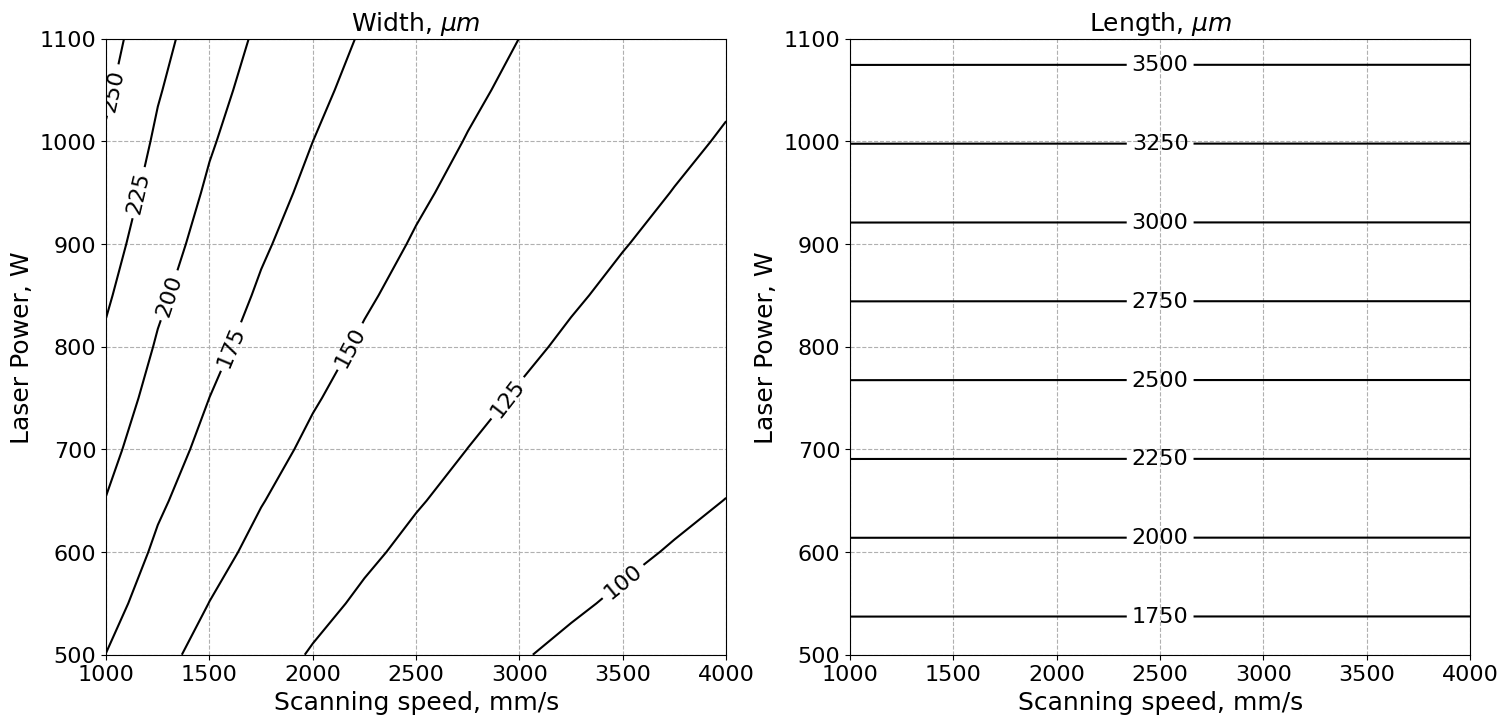

In [ ]:
    ww = np.array(width).reshape(PP.shape)
    ll = np.array(length).reshape(PP.shape)

    width = 8   # 正方形の図形を作成するために図のサイズを設定
    fig = plt.figure(figsize=(2.2*width, width))
    ax1 = fig.add_subplot(1,2,1)
    Plot_contour(ax1, vv*1E+3, PP, ww, r'Width, $\mu m$')
    ax2 = fig.add_subplot(1,2,2)
    Plot_contour(ax2, vv*1E+3, PP, ll, r'Length, $\mu m$')
    plt.show()


In [ ]:

    #nn = np.array(n).reshape(PP.shape)
    ww = np.array(width).reshape(PP.shape) * 2.0*alph/ve * 1.0E+6
    ll = np.array(length).reshape(PP.shape) * 2.0*alph/ve * 1.0E+6
    #ll = nn * 2.0*alph/ve * 1.0E+6

    width = 8   # 正方形の図形を作成するために図のサイズを設定
    fig = plt.figure(figsize=(2.2*width, width))
    ax1 = fig.add_subplot(1,2,1)
    Plot_contour(ax1, vv*1E+3, PP, ww, r'Width $\mu m$')
    ax2 = fig.add_subplot(1,2,2)
    Plot_contour(ax2, vv*1E+3, PP, ll, 'Length, um')
    plt.show()

    #Plot_contour(ax1, vv*1E+3, PP, nn, 'Operating Parameter, N, -')


    # xx0 = np.array(xi0).reshape(PP.shape)
    # ax3 = fig.add_subplot(1,3,3)
    # # xx1 = np.array(xi1).reshape(PP.shape)
    # xx2 = np.array(xi2).reshape(PP.shape)
    # Plot_contour(vv*1E+3, PP, xx0)
    # Plot_contour(vv*1E+3, PP, xx1)
    # Plot_contour(vv*1E+3, PP, xx2)
    # Plot_contour(ax3, vv*1E+3, PP, xx0 * 2.0*alph/ve * 1.0E+6, r'$\xi_0$')


    # ww = np.array(width).reshape(PP.shape)
    # Plot_contour(vv*1E+3, PP, ww)

    # ll = np.array(length).reshape(PP.shape)
    # Plot_contour(vv*1E+3, PP, ll)

    # ll = np.array(length)[:, 0].reshape(PP.shape)
    # Plot_contour(vv*1E+3, PP, ll)

    # ll = np.array(length)[:, 1].reshape(PP.shape)
    # Plot_contour(vv*1E+3, PP, ll)

    # ll = np.array(length)[:, 2].reshape(PP.shape)
    # Plot_contour(vv*1E+3, PP, ll)

    # bb = np.array(tb).reshape(PP.shape)
    # Plot_contour(vv*1E+3, PP, bb)

    # ss = np.array(ts).reshape(PP.shape)
    # Plot_contour(vv*1E+3, PP, ss)

    # bb2 = (np.array(tb)*vv.ravel()).reshape(PP.shape)
    # Plot_contour(vv*1E+3, PP, bb2)
    # # width = 8   # 正方形の図形を作成するために図のサイズを設定
    # fig = plt.figure(figsize=(width, width))
    # ax1 = fig.add_subplot(111)
    # contour = plt.contour(vv*1E+3, PP, bb2, colors='black')
    # plt.clabel(contour, inline=True, fontsize=16)
    # plt.xlabel('Scanning speed, mm/s', fontsize=18)
    # plt.ylabel('Laser Power, W', fontsize=18)
    # plt.xticks(fontsize=16)    # fontsize of the tick labels
    # plt.yticks(fontsize=16)    # fontsize of the tick labels
    # plt.grid(linestyle='dashed')    # 罫線を追加
    # plt.show()

ValueError: ignored